In [1]:
from Funcs.Utility import *

# Cross-validation

## Implementation

### CV Pipeline

In [2]:
def exclude_low_variance(agg_feature, threshold=.0000001):
    agg_feature_non_zero_var = agg_feature.loc[:,agg_feature.var()>threshold]
    num_removed = agg_feature.shape[1]-agg_feature_non_zero_var.shape[1]
    print(f'{num_removed}/{agg_feature.shape[1]} features with variance < {threshold} removed')
    return agg_feature_non_zero_var

In [3]:
from tqdm import tqdm
def remove_pairwise_corr(agg_feature_percent_missing, PAIRWISE_CORR_THRESHOLD=0.8, outcome_variable=None):
    if outcome_variable is not None:
        outcome_variable = pd.Series(outcome_variable, index=agg_feature_percent_missing.index, name="outcome")
        corr_with_outcome = pd.merge(outcome_variable, agg_feature_percent_missing, left_index=True, right_index=True).corr()[outcome_variable.name].abs().sort_values(ascending=False)
        importance_order = corr_with_outcome.index[1:].tolist()
        agg_feature_percent_missing = agg_feature_percent_missing[importance_order]

    Matrix = agg_feature_percent_missing.corr().abs()
    
    upper_triangle = Matrix.where(np.triu(np.ones(Matrix.shape), k=1).astype(bool))

    correlated_features = set()
    for feature in upper_triangle.columns:
        highly_correlated = upper_triangle[feature][upper_triangle[feature] > PAIRWISE_CORR_THRESHOLD].index
        correlated_features.update(highly_correlated)

    kept_features = list(set(agg_feature_percent_missing.columns) - correlated_features)
    print(f"Pairwise Corr: kept only {len(kept_features)}/{len(agg_feature_percent_missing.columns)} features")
    return agg_feature_percent_missing[kept_features]


In [4]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import LeaveOneGroupOut

class CustomCV:
    def __init__(self, n_splits):
        self.n_splits = n_splits

    def split(self, X, y, groups):
        logo = LeaveOneGroupOut()

        for train_users, test_users in logo.split(X, y, groups):
            X_train_users, X_test_user = X.loc[train_users], X.loc[test_users]
            y_train_users, y_test_user = y[train_users], y[test_users]
            group_train_users, group_test_user = groups[train_users], groups[test_users]

            tscv = TimeSeriesSplit(n_splits=self.n_splits) 

            # only take the first split
            train_index, test_index = next(tscv.split(X_test_user))
            
            X_train, X_test = pd.concat([X_train_users, X_test_user.iloc[train_index]]), X_test_user.iloc[test_index]
            y_train, y_test = np.concatenate([y_train_users, y_test_user[train_index]]), y_test_user[test_index]

            yield (X_train.index, X_test.index)

In [5]:
import os
import pandas as pd
import numpy as np
import traceback as tb
from contextlib import contextmanager
from typing import Tuple, Dict, Union, Generator, List
from dataclasses import dataclass
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.base import BaseEstimator, clone
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold, LeaveOneGroupOut, StratifiedShuffleSplit, RepeatedStratifiedKFold, StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
import time
import ray
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, LSTM
# from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator



@dataclass
class FoldResult:
    name: str
    estimator: BaseEstimator
    X_train: pd.DataFrame
    y_train: np.ndarray
    X_test: pd.DataFrame
    y_test: np.ndarray
    categories: Dict[str, Dict[int, str]] = None
    datetimes_train: np.ndarray = None
    datetimes_test: np.ndarray = None



def _split(
        alg: str,
        X: Union[pd.DataFrame, np.ndarray] = None,
        y: np.ndarray = None,
        groups: np.ndarray = None,
        random_state: int = None,
        n_splits: int = None,
        n_repeats: int = None,
        test_ratio: float = None
) -> Generator[Tuple[np.ndarray, np.ndarray], None, None]:
    if alg == 'holdout':
        splitter = StratifiedShuffleSplit(
            n_splits=n_splits,
            test_size=test_ratio,
            random_state=random_state
        )
    elif alg == 'kfold':
        if n_repeats and n_repeats > 1:
            splitter = RepeatedStratifiedKFold(
                n_splits=n_splits,
                n_repeats=n_repeats,
                random_state=random_state,
            )
        else:
            splitter = StratifiedKFold(
                n_splits=n_splits,
                random_state=random_state,
                shuffle=False if random_state is None else True,
            )
    elif alg == 'logo':
        splitter = LeaveOneGroupOut()
    elif alg == 'groupk':
        splitter = StratifiedGroupKFold(n_splits=n_splits)
    elif alg == 'TimeSeriesSplit':
        splitter = TimeSeriesSplit(n_splits=n_splits)
    elif alg == 'custom_cv':
        splitter = CustomCV(n_splits=n_splits)
        
    else:
        raise ValueError('"alg" should be one of "holdout", "kfold", "logo", "TimeSeriesSplit", "custom_cv" or "groupk".')

    split = splitter.split(X, y, groups)

    for I_train, I_test in split:
        yield I_train, I_test


def _train(
    dir_result: str,
    name: str,
    datetimes_train: np.ndarray,  # Add datetimes_train parameter
    datetimes_test: np.ndarray,  # Add datetimes_test parameter

    X_train: pd.DataFrame,
    y_train: np.ndarray,
    X_test: pd.DataFrame,
    y_test: np.ndarray,
    C_cat: np.ndarray,
    C_num: np.ndarray,
    estimator: BaseEstimator,
    normalize: bool = False,
    select: Union[List[SelectFromModel], SelectFromModel] = None,
    oversample: bool = False,
    random_state: int = None,
    categories: Union[List, Dict[str, Dict[int, str]]] = None


):
    @contextmanager
    def _log(task_type: str):
        log(f'In progress: {task_type}.')
        _t = time.time()
        _err = None
        _result = dict()
        
        try:
            yield _result
        except:
            _err = tb.format_exc()
        finally:
            _e = time.time() - _t
            if _err:
                _msg = f'Failure: {task_type} ({_e:.2f}s). Keep running without this task. Caused by: \n{_err}' 
            else:
                _msg = f'Success: {task_type} ({_e:.2f}s).' 
                if _result:
                    _r = '\n'.join([f'- {k}: {v}' for k, v in _result.items()])
                    _msg = f'{_msg}\n{_r}'
            log(_msg)
        #Instead of using fixed threshold, we tried to use mean value as threshold for binarization
# #     y_train_mean = np.mean(np.concatenate((y_train,y_test)))
#     y_train_mean = np.mean(y_train)
#     y_train = np.where(y_train > y_train_mean, 1, 0)
#     y_test= np.where(y_test > y_train_mean, 1, 0)
# #     X_train['ESM#LastLabel'] = np.where(X_train['ESM#LastLabel'] > y_train_mean, 1, 0)
# #     X_test['ESM#LastLabel'] = np.where(X_test['ESM#LastLabel'] > y_train_mean, 1, 0)
    
    if normalize:
        with _log(f'[{name}] Normalizing numeric features'):
            X_train_N, X_test_N = X_train[C_num].values, X_test[C_num].values
            X_train_C, X_test_C = X_train[C_cat].values, X_test[C_cat].values
            
            scaler = StandardScaler().fit(X_train_N)
            X_train_N = scaler.transform(X_train_N)
            X_test_N = scaler.transform(X_test_N)
         
            X_train = pd.DataFrame(
                np.concatenate((X_train_C, X_train_N), axis=1),
                columns=np.concatenate((C_cat, C_num))
            )
            X_test = pd.DataFrame(
                np.concatenate((X_test_C, X_test_N), axis=1),
                columns=np.concatenate((C_cat, C_num))
            )
           
    if select:
        # Removing low variance features
#         X_train = exclude_low_variance(X_train)
#         X_test = X_test[X_train.columns]  # Keep only the selected features in the test set

        # Removing highly correlated features
#         X_train = remove_pairwise_corr(X_train, outcome_variable= y_train)
#         X_test = X_test[X_train.columns]  # Keep only the selected features in the test set

        if isinstance(select, SelectFromModel):
            select = [select]
            
        for i, s in enumerate(select):
            with _log(f'[{name}] {i+1}-th Feature selection') as r:
                C = np.asarray(X_train.columns)
                r['# Orig. Feat.'] = f'{len(C)} (# Cat. = {len(C_cat)}; # Num. = {len(C_num)})'
                M = s.fit(X=X_train.values, y=y_train).get_support()
                C_sel = C[M]
                C_cat = C_cat[np.isin(C_cat, C_sel)]
                C_num = C_num[np.isin(C_num, C_sel)]
                
                X_train_N, X_test_N = X_train[C_num].values, X_test[C_num].values
                X_train_C, X_test_C = X_train[C_cat].values, X_test[C_cat].values


                X_train = pd.DataFrame(
                    np.concatenate((X_train_C, X_train_N), axis=1),
                    columns=np.concatenate((C_cat, C_num))
                )
                X_test = pd.DataFrame(
                    np.concatenate((X_test_C, X_test_N), axis=1),
                    columns=np.concatenate((C_cat, C_num))
                )
                r['# Sel. Feat.'] = f'{len(C_sel)} (# Cat. = {len(C_cat)}; # Num. = {len(C_num)})'

    if oversample:
        with _log(f'[{name}] Oversampling') as r:
            if len(C_cat):
                M = np.isin(X_train.columns, C_cat)
                sampler = SMOTENC(categorical_features=M, random_state=random_state)
            else:
                sampler = SMOTE(random_state=random_state)
            X_train, y_train = sampler.fit_resample(X_train, y_train)
#             # Create oversampled datetimes_train
#             datetimes_train_oversampled = np.repeat(datetimes_train, sampler.sample_indices_.shape[0], axis=0)

    # You can access the underlying model class like this:

    with _log(f'[{name}] Training'):
        estimator = estimator.fit(X_train, y_train)
        result = FoldResult(
            name=name,
            estimator=estimator,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            categories=categories
        )
        dump(result, os.path.join(dir_result, f'{name}.pkl'))
    

def cross_val(
    X: pd.DataFrame,
    y: np.ndarray,
    groups: np.ndarray,
    datetimes:  np.ndarray,
    path: str,
    name: str,
    estimator: BaseEstimator,
    categories: List[str] = None,
    normalize: bool = False,
    split: str = None,
    split_params: Dict[str, any] = None,
    select: Union[List[SelectFromModel], SelectFromModel] = None,
    oversample: bool = False,
    random_state: int = None

):
    if not os.path.exists(path):
        raise ValueError('"path" does not exist.')
    
    if not split:
        raise ValueError('"split" should be specified.')
    
    if not ray.is_initialized():
        raise EnvironmentError('"ray" should be initialized.')
    
    jobs = []
    func = ray.remote(_train).remote

    categories = list() if categories is None else categories
    C_cat = np.asarray(sorted(categories))
    C_num = np.asarray(sorted(X.columns[~X.columns.isin(C_cat)]))

    split_params = split_params or dict()
    splitter = _split(alg=split, X=X, y=y, groups=groups, random_state=random_state, **split_params)
    
    

    for idx_fold, (I_train, I_test) in enumerate(splitter):
        if split == 'logo':
            FOLD_NAME = str(np.unique(groups[I_test]).item(0))
        else:
            FOLD_NAME = str(idx_fold + 1)

        X_train, y_train = X.iloc[I_train, :], y[I_train]
        X_test, y_test = X.iloc[I_test, :], y[I_test]
        datetimes_train, datetimes_test = datetimes[I_train], datetimes[I_test]  # Add datetimes_train and datetimes_test


        job = func(
            dir_result=path,
            
            datetimes_train=datetimes_train,  # Pass datetimes_train
            datetimes_test=datetimes_test,  # Pass datetimes_test

            name=f'{name}#{FOLD_NAME}',
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            C_cat=C_cat,
            C_num=C_num,
            categories=categories,
            estimator=clone(estimator),
            normalize=normalize,
            select=select,
            oversample=oversample,
            random_state=random_state

        )
        jobs.append(job)
    ray.get(jobs)

### Minor Modification on XGBClassifer
This modification allows XGBClassifiers to automatically generate evaluation sets during pipeline (without passing any argument in "fit" function)

In [19]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator
from sklearn.model_selection import StratifiedShuffleSplit
from typing import Union


class EvXGBClassifier(BaseEstimator):
    def __init__(
        self,
        eval_size=None,
        eval_metric='logloss',
        early_stopping_rounds=10,
        random_state=None,
        **kwargs
        ):
        self.random_state = random_state
        self.eval_size = eval_size
        self.eval_metric = eval_metric
        self.early_stopping_rounds = early_stopping_rounds
        self.model = XGBClassifier(
            random_state=self.random_state,
            eval_metric=self.eval_metric,
            early_stopping_rounds=self.early_stopping_rounds,
            **kwargs
        )

    @property
    def classes_(self):
        return self.model.classes_

    @property
    def feature_importances_(self):
        return self.model.feature_importances_
    
    @property
    def feature_names_in_(self):
        return self.model.feature_names_in_

    def fit(self, X: Union[pd.DataFrame, np.ndarray], y: np.ndarray):
        if self.eval_size:
            splitter = StratifiedShuffleSplit(random_state=self.random_state, test_size=self.eval_size)
            I_train, I_eval = next(splitter.split(X, y))
            if isinstance(X, pd.DataFrame):
                X_train, y_train = X.iloc[I_train, :], y[I_train]
                X_eval, y_eval = X.iloc[I_eval, :], y[I_eval]
            else:
                X_train, y_train = X[I_train, :], y[I_train]
                X_eval, y_eval = X[I_eval, :], y[I_eval]
                
            self.model = self.model.fit(
                X=X_train, y=y_train, 
                eval_set=[(X_eval, y_eval)],
                verbose=False
            )
        else:
            self.model = self.model.fit(X=X, y=y, verbose=False)
        return self

    def predict(self, X: pd.DataFrame):
        return self.model.predict(X)

    def predict_proba(self, X: pd.DataFrame):
        return self.model.predict_proba(X)

## Execution

In [11]:
LABELS_PROC = pd.read_csv(os.path.join(PATH_INTERMEDIATE, 'proc', 'LABELS_PROC.csv'), index_col=['pcode','timestamp'],parse_dates=True)

In [17]:
import os
from itertools import product
from sklearn.base import clone
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from eli5.sklearn.permutation_importance import PermutationImportance
import numpy as np



RANDOM_STATE = 42

ESTIMATOR_DUMMY = DummyClassifier(strategy='prior')
ESTIMATOR_RF = RandomForestClassifier(random_state=RANDOM_STATE)
ESTIMATOR_XGB = EvXGBClassifier(
    random_state=RANDOM_STATE, 
    eval_metric='logloss', 
    eval_size=0.2,
    early_stopping_rounds=10, 
    objective='binary:logistic', 
    verbosity=0,
    learning_rate=0.01
)
ESTIMATOR_LR = LogisticRegression(random_state = RANDOM_STATE, max_iter=500 )
ESTIMATOR_KNN = KNeighborsClassifier()
ESTIMATOR_SVM = SVC(probability=True)
ESTIMATOR_GP = GaussianProcessClassifier(random_state=RANDOM_STATE)
ESTIMATOR_DT = DecisionTreeClassifier(random_state = RANDOM_STATE)
ESTIMATOR_MLP = MLPClassifier(random_state=RANDOM_STATE, max_iter=2000)
ESTIMATOR_ADAB = AdaBoostClassifier(random_state=RANDOM_STATE)
ESTIMATOR_GNB = GaussianNB()
ESTIMATOR_QDA = QuadraticDiscriminantAnalysis()
# ESTIMATOR_LSTM = LSTMWrapper()

  

SELECT_SVC = SelectFromModel(
#     estimator=LinearSVC(
#         penalty='l1',
#         loss='squared_hinge',
#         dual=False,
#         tol=1e-3,
#         C=1e-2,
#         max_iter=5000,
#         random_state=RANDOM_STATE
#     ),
    
        estimator=LogisticRegression(
        penalty='l1' 
        ,solver='liblinear'
        , C=1, random_state=RANDOM_STATE, max_iter=4000
    ),
#     threshold=1e-5
    threshold = 0.005
)

# CLS = ['valence', 'arousal', 'stress', 'disturbance']
CLS = ['stress']

SETTINGS = [
#     dict(
#         estimator=clone(ESTIMATOR_DUMMY),
#         oversample=False,
#         select=None,
#         name='dummy'
#     ),
#     dict(
#         estimator=clone(ESTIMATOR_RF),
#         oversample=False,
#         select=[clone(SELECT_SVC)],
#         name='rf_ns'
#     ),
#     dict(
#         estimator=clone(ESTIMATOR_RF),
#         oversample=True,
#         select=[clone(SELECT_SVC)],
#         name='rf_os'
#     ),
#     dict(
#         estimator=clone(ESTIMATOR_XGB),
#         oversample=False,
#         select=[clone(SELECT_SVC)],
#         name='xgb_ns'
#     ),
    dict(
        estimator=clone(ESTIMATOR_XGB),
        oversample=True,
        select=[clone(SELECT_SVC)],
        name='xgb_os'
    ),
#     dict(
#         estimator=clone(ESTIMATOR_LR),
#         oversample=True,
#         select=[clone(SELECT_SVC)],
#         name='lr_os'
#     ),
#     dict(
#         estimator=clone(ESTIMATOR_KNN),
#         oversample=True,
#         select=[clone(SELECT_SVC)],
#         name='knn_os'
#     ),
#     dict(
#         estimator=clone(ESTIMATOR_SVM),
#         oversample=True,
#         select=[clone(SELECT_SVC)],
#         name='svm_os'
#     ),
#     dict(
#         estimator=clone(ESTIMATOR_DT),
#         oversample=True,
#         select=[clone(SELECT_SVC)],
#         name='dt_os'
#     ),
#     dict(
#         estimator=clone(ESTIMATOR_MLP),
#         oversample=True,
#         select=[clone(SELECT_SVC)],
#         name='mlp_os'
#     ),
#     dict(
#         estimator=clone(ESTIMATOR_ADAB),
#         oversample=True,
#         select=[clone(SELECT_SVC)],
#         name='adab_os'
#     ),
#         dict(
#         estimator=clone(ESTIMATOR_GP),
#         oversample=True,
#         select=[clone(SELECT_SVC)],
#         name='gp_os'
#     ),
#             dict(
#         estimator=clone(ESTIMATOR_GNB),
#         oversample=True,
#         select=[clone(SELECT_SVC)],
#         name='gnb_os'
#     ),
#             dict(
#         estimator=clone(ESTIMATOR_QDA),
#         oversample=True,
#         select=[clone(SELECT_SVC)],
#         name='qda_os'
#     ),
#     dict(
#         estimator=clone(ESTIMATOR_LSTM),
#         oversample=None,
#         lookback=lookback,
#         select=[clone(SELECT_SVC)],
#         name='lstm_os'
#     )
]



p = os.path.join(PATH_INTERMEDIATE, 'feat',f'stress-fixed.pkl')
par_dir = os.path.join(PATH_INTERMEDIATE, 'eval', 'stress')

if os.path.isdir(par_dir):
    # Get a list of all the files in the folder
    files = os.listdir(par_dir)

    # Delete all the files in the folder
    for file in files:
        if file !='.ipynb_checkpoints':
            os.remove(os.path.join(par_dir, file))
os.makedirs(par_dir, exist_ok=True)

#with on_ray(num_cpus=6):
with on_ray():
    for l, s in product(
        CLS, SETTINGS
    ):       
        X, y, groups, t, datetimes = load(p)
        ################################################
        #Use mean threshold for all users (only training set,\ 
        #we need to use raw value and binarize after data splitting)
#         y =  LABELS_PROC['stress'].to_numpy()
        #Use user speicifc mean threshold
#         y =LABELS_PROC['stress_user_mean'].to_numpy()
        #Use fixed threshold
#         y =LABELS_PROC['stress_fixed'].to_numpy()
        #Use three categories (fixed threshold) 
#        y =LABELS_PROC['stress_fixed_tri'].to_numpy()

        
        #The following code is designed for reordering for the sake of time series split
        #################################################
        # Create a DataFrame with user_id and datetime
#         df = pd.DataFrame({'user_id': groups, 'datetime': pd.to_datetime(datetimes)})

#         # Normalize the datetime for each user
# #         df['datetime'] = df.groupby('user_id')['datetime'].transform(lambda x: x - x.min())
#         df['datetime'] = df.groupby('user_id')['datetime'].transform(lambda x: x - x.min().normalize())

#         # Sort the DataFrame by datetime
# #         df = df.sort_values(by=['user_id', 'datetime'])
#         df = df.sort_values(by=[ 'datetime'])
#         # Shuffle the DataFrame
# #         df = df.sample(frac=1, random_state=RANDOM_STATE)

#         # Update groups and datetimes
#         groups = df['user_id'].to_numpy()
#         datetimes = df['datetime'].dt.total_seconds().to_numpy()  # convert to seconds

#         # Use the new order to reorder X and y
#         X = X.reindex(df.index)
#         y = y[df.index]
#         ###################################################
        

        #The following code is for only using 1st day
        ###########################################
#         filtered_df = pd.read_csv(os.path.join(PATH_INTERMEDIATE,'exclude_1st_day.csv'),index_col=0)
#         X_filtered = X[~X.index.isin(filtered_df.index)]
#         y_series = pd.Series(y, index=X.index)
#         y_filtered = y_series[~y_series.index.isin(filtered_df.index)]
#         y_filtered = y_filtered.values
#         groups_series = pd.Series(groups, index=X.index)
#         groups_filtered = groups_series[~groups_series.index.isin(filtered_df.index)]
#         groups_filtered = groups_filtered.values
#         X,y, groups=X_filtered,y_filtered, groups_filtered
        #The following code is for excluding using 1st day
        ###########################################
#         filtered_df = pd.read_csv(os.path.join(PATH_INTERMEDIATE,'exclude_1st_day.csv'),index_col=0)
#         X_filtered = X[X.index.isin(filtered_df.index)]
#         y_series = pd.Series(y, index=X.index)
#         y_filtered = y_series[y_series.index.isin(filtered_df.index)]
#         y_filtered = y_filtered.values
#         groups_series = pd.Series(groups, index=X.index)
#         groups_filtered = groups_series[groups_series.index.isin(filtered_df.index)]
#         groups_filtered = groups_filtered.values
#         X,y, groups=X_filtered,y_filtered, groups_filtered
        
        
        ###########################################
        #The following code is for similar-user model
        ###########################################
#         similar_user = pd.read_csv(os.path.join(PATH_INTERMEDIATE,  'similar_user.csv'))
#         cluster_label = similar_user['cluster'].value_counts().index[0] #N number clusters
#         similar_users_in_cluster = similar_user[similar_user['cluster'] == cluster_label]['pcode']

#         # Check if each value in 'groups' is in 'similar_users_in_cluster'
#         mask = np.isin(groups, similar_users_in_cluster)

#         # Filter 'groups' based on the mask
#         filtered_groups = groups[mask]
#         # Filter 'X' and 'y' based on the mask
#         X_filtered = X[mask]
#         y_filtered = y[mask]
#         X,y, groups=X_filtered,y_filtered, filtered_groups
        ###########################################
        #Remove low frequency features
#         mask = ['CAE#', 'MED#', 'ONF#', 'PWS#', 'RNG#','MSG#' ]
#         X = X.loc[:, [all(m not in str(x) for m in mask) for x in X.columns]]

        #Divide the features into different categories
        feat_current = X.loc[:,[('#VAL' in str(x)) or ('ESM#LastLabel' in str(x)) for x in X.keys()]]  
        feat_dsc = X.loc[:,[('#DSC' in str(x))  for x in X.keys()]]  
        feat_yesterday = X.loc[:,[('Yesterday' in str(x))  for x in X.keys()]]  
        feat_today = X.loc[:,[('Today' in str(x))  for x in X.keys()]]  
        feat_sleep = X.loc[:,[('Sleep' in str(x))  for x in X.keys()]]  
        feat_time = X.loc[:,[('Time' in str(x))  for x in X.keys()]]  
        feat_pif = X.loc[:,[('PIF' in str(x))  for x in X.keys()]]  
        feat_ImmediatePast = X.loc[:,[('ImmediatePast_15' in str(x))  for x in X.keys()]]
        #Divide the time window features into sensor/past stress label
        feat_current_sensor = X.loc[:,[('#VAL' in str(x))  for x in X.keys()]]  
        feat_current_ESM = X.loc[:,[('ESM#LastLabel' in str(x)) for x in X.keys()]]  
        feat_ImmediatePast_sensor = feat_ImmediatePast.loc[:,[('ESM' not in str(x)) for x in feat_ImmediatePast.keys()]]  
        feat_ImmediatePast_ESM = feat_ImmediatePast.loc[:,[('ESM'  in str(x)) for x in feat_ImmediatePast.keys()]]  
        feat_today_sensor = feat_today.loc[:,[('ESM' not in str(x))  for x in feat_today.keys()]]  
        feat_today_ESM = feat_today.loc[:,[('ESM'  in str(x)) for x in feat_today.keys()]]  
        feat_yesterday_sensor = feat_yesterday.loc[:,[('ESM' not in str(x)) for x in feat_yesterday.keys()]]  
        feat_yesterday_ESM = feat_yesterday.loc[:,[('ESM'  in str(x)) for x in feat_yesterday.keys()]]



        #Prepare the final feature set
        feat_baseline = pd.concat([ feat_time,feat_dsc,feat_current_sensor, feat_ImmediatePast_sensor],axis=1)
        #The following code is for calculating aggregated features
        ########################################################################
        # Define a function to split the column name into sensor and attribute
#         def split_column_name(col_name):
#             parts = col_name.rsplit("#", 1)  # Split on last occurrence of '#'
#             return parts[0]  # This gives you 'Sensor#Attribute'

#         # Get a list of unique sensor-attribute combinations
#         df=feat_yesterday_sensor
#         sensor_attributes = df.columns.map(split_column_name).unique()

#         # Create a list to hold the aggregated results
#         agg_results = []

#         # Loop over each sensor-attribute, select the appropriate columns, compute the mean and std
#         for sensor_attribute in sensor_attributes:
#             # Select columns for this sensor-attribute
#             cols_to_aggregate = [col for col in df.columns if col.startswith(sensor_attribute)]
#             # Compute the mean and std and store in the new DataFrame
#             agg_results.append(df[cols_to_aggregate].mean(axis=1).rename(sensor_attribute + '|'+ 'MEAN'))
#             agg_results.append(df[cols_to_aggregate].std(axis=1).rename(sensor_attribute + '|'+'STD'))

#         # Concatenate all the results into a single DataFrame
#         agg_feature = pd.concat(agg_results, axis=1)
        #########################################################################
        feat_final = pd.concat([feat_baseline ],axis=1)
        X = feat_final
        
        cats = X.columns[X.dtypes == bool]
        
        cross_val(
            X=X, y=y, groups=groups, datetimes =datetimes,
            path=par_dir,
            normalize=True,
            split='logo',
            categories=cats,
            split_params={'n_splits' : 5},
            random_state=RANDOM_STATE,
            **s
        )

2023-09-06 15:16:26,460	INFO worker.py:1452 -- Connecting to existing Ray cluster at address: 192.168.1.28:6379...
2023-09-06 15:16:26,470	INFO worker.py:1627 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 


(_train pid=1139346) [23-09-06 15:16:27] In progress: [xgb_os#P02] Normalizing numeric features.
(_train pid=349620, ip=192.168.1.27) [23-09-06 15:16:27] Success: [xgb_os#P31] Normalizing numeric features (0.03s).
(_train pid=349620, ip=192.168.1.27) [23-09-06 15:16:27] In progress: [xgb_os#P31] 1-th Feature selection.
(_train pid=349702, ip=192.168.1.27) [23-09-06 15:16:41] Success: [xgb_os#P39] 1-th Feature selection (12.43s).
(_train pid=349702, ip=192.168.1.27) - # Orig. Feat.: 571 (# Cat. = 0; # Num. = 571)
(_train pid=349702, ip=192.168.1.27) - # Sel. Feat.: 423 (# Cat. = 0; # Num. = 423)
(_train pid=349702, ip=192.168.1.27) [23-09-06 15:16:41] In progress: [xgb_os#P39] Oversampling.
(_train pid=349813, ip=192.168.1.27) [23-09-06 15:16:29] In progress: [xgb_os#P49] Normalizing numeric features. [repeated 27x across cluster]
(_train pid=349813, ip=192.168.1.27) [23-09-06 15:16:29] Success: [xgb_os#P49] Normalizing numeric features (0.05s). [repeated 27x across cluster]
(_train pid

Autocorrelation

In [9]:
X, y, groups, t, datetimes = load(p)

# Calculate the Pearson correlation coefficient
r = np.corrcoef(X['ESM#LastLabel'], y)[0, 1]

In [10]:
 r

0.25318770878842567

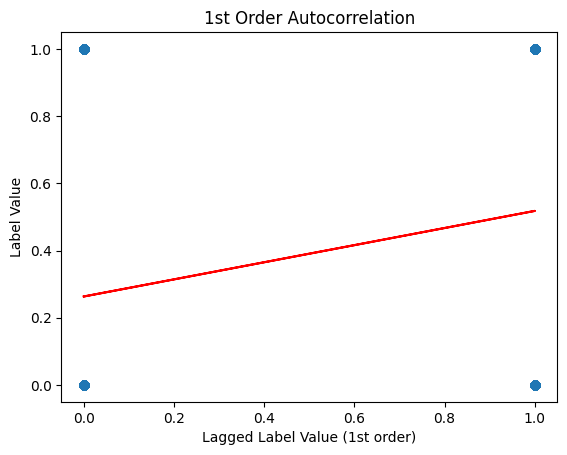

In [11]:
import matplotlib.pyplot as plt

# Assuming you have two series: series1 and series2
series1 = X['ESM#LastLabel']
series2 = y
# Create a scatter plot
plt.scatter(series1, series2)
plt.xlabel('Lagged Label Value (1st order)')
plt.ylabel('Label Value')
plt.title('1st Order Autocorrelation')

# Add a trendline (optional)
z = np.polyfit(series1, series2, 1)
p = np.poly1d(z)
plt.plot(series1, p(series1), color='r')

# Show the plot
plt.show()
